In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# Introducing k-Means
The k-means algo searches for a pre-determined number of clusters within an unlabeled multidimensional dataset. It accomplishes this using a simple conception of what the optimal clustering looks like:

1) the 'cluster center' is the arithmetic mean of all the points belonging to the cluster.
2) each point is closer to its own cluster than to other cluster centers.

Those assumptions are the basis of the k-means model. We will soon dive into exactly how the algo reaches this solution, but for now let's take a look at a simple dataset and see the k-means result.

First, let's generate a two-dimensional dataset containing four distinct blobs. To emphasize that this is an unsupervised algo, we will leave the labels out of the visualization.

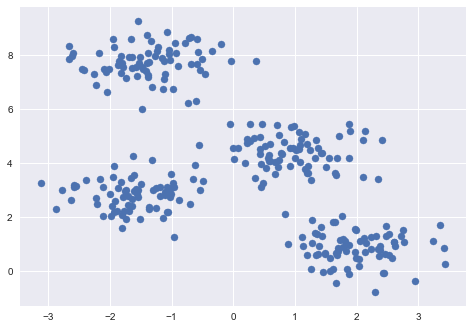

In [4]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers = 4, 
                      cluster_std = 0.60, random_state=0)
plt.scatter(X[:,0], X[:,1], s = 50);

In [5]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

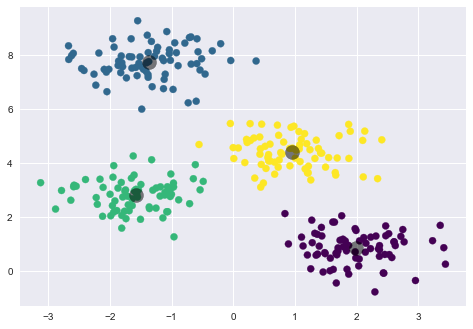

In [7]:
plt.scatter(X[:,0], X[:,1], c= y_kmeans, s = 50, cmap = 'viridis')

centers =kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c= 'black', s = 200, alpha =0.5);

The good news is that the k-means algo (at least in this simple cae) assigns the points to clusters very similarly to how we might assign them by eye. But you might wonder how this algo finds these clusters so quickly! After all, the no of possible combinations of cluster assignments is exponential in the no of data points - an exhaustive search would be very, very costly. Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to k-means involves an intuitive iterative approach known as expectation-maximisation.

# K-means algo: EM
EM is a powerful algo that comes up in a variety of contexts within data science. k-means is a particuarly simple and easy-to-understand application of the algo, and we will walk through it briefly here. In short, the EM approach here consists of the following procedure:

1. Guess some cluster centers
2. Repeat until converged
    A. E-step: assign points to the nearest cluster center
    B. M-step: set the cluster centers to the mean
    
Here the E-step is so-named because it involves updating our expectation of which cluster each point belongs to. The M-step is so-named because it involves maximising some fitness function that defines the location of the cluster centers- in this case, that maximisation is accomplished by taking a simple mean of the data in each cluster.


The following figure shows a visual depiction of the EM approach to Kmeans:

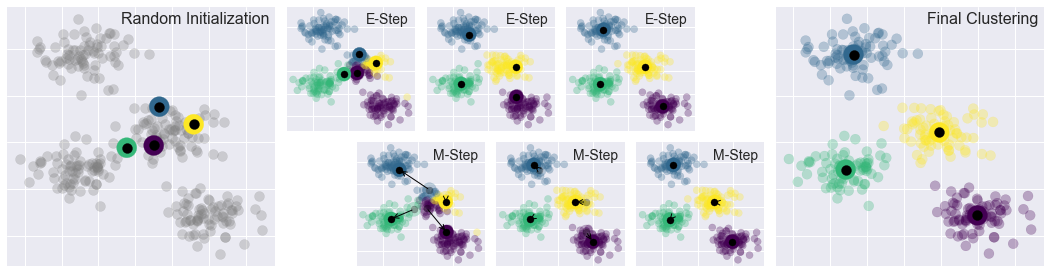

In [8]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import pairwise_distances_argmin

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

rng = np.random.RandomState(42)
centers = [0, 4] + rng.randn(4, 2)

def draw_points(ax, c, factor=1):
    ax.scatter(X[:, 0], X[:, 1], c=c, cmap='viridis',
               s=50 * factor, alpha=0.3)
    
def draw_centers(ax, centers, factor=1, alpha=1.0):
    ax.scatter(centers[:, 0], centers[:, 1],
               c=np.arange(4), cmap='viridis', s=200 * factor,
               alpha=alpha)
    ax.scatter(centers[:, 0], centers[:, 1],
               c='black', s=50 * factor, alpha=alpha)

def make_ax(fig, gs):
    ax = fig.add_subplot(gs)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    return ax

fig = plt.figure(figsize=(15, 4))
gs = plt.GridSpec(4, 15, left=0.02, right=0.98, bottom=0.05, top=0.95, wspace=0.2, hspace=0.2)
ax0 = make_ax(fig, gs[:4, :4])
ax0.text(0.98, 0.98, "Random Initialization", transform=ax0.transAxes,
         ha='right', va='top', size=16)
draw_points(ax0, 'gray', factor=2)
draw_centers(ax0, centers, factor=2)

for i in range(3):
    ax1 = make_ax(fig, gs[:2, 4 + 2 * i:6 + 2 * i])
    ax2 = make_ax(fig, gs[2:, 5 + 2 * i:7 + 2 * i])
    
    # E-step
    y_pred = pairwise_distances_argmin(X, centers)
    draw_points(ax1, y_pred)
    draw_centers(ax1, centers)
    
    # M-step
    new_centers = np.array([X[y_pred == i].mean(0) for i in range(4)])
    draw_points(ax2, y_pred)
    draw_centers(ax2, centers, alpha=0.3)
    draw_centers(ax2, new_centers)
    for i in range(4):
        ax2.annotate('', new_centers[i], centers[i],
                     arrowprops=dict(arrowstyle='->', linewidth=1))
        
    
    # Finish iteration
    centers = new_centers
    ax1.text(0.95, 0.95, "E-Step", transform=ax1.transAxes, ha='right', va='top', size=14)
    ax2.text(0.95, 0.95, "M-Step", transform=ax2.transAxes, ha='right', va='top', size=14)


# Final E-step    
y_pred = pairwise_distances_argmin(X, centers)
axf = make_ax(fig, gs[:4, -4:])
draw_points(axf, y_pred, factor=2)
draw_centers(axf, centers, factor=2)
axf.text(0.98, 0.98, "Final Clustering", transform=axf.transAxes,
         ha='right', va='top', size=16)

The following is a very basic implementation

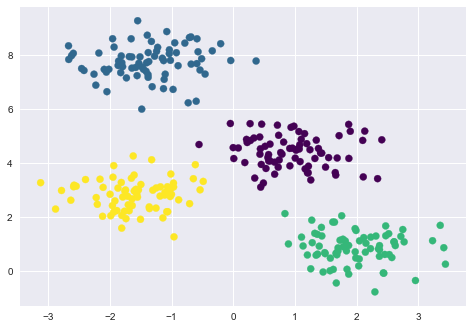

In [10]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    #1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        #2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        #2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                               for i in range(n_clusters)])
        
        #2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X,4)
plt.scatter(X[:,0], X[:,1], c = labels,
           s = 50, cmap='viridis');

Most well-tested implementations will do a bit more than this under the hood, but the preceding function gives the gist of the EM approach.

# Caveats of EM
There are a few issues to be aware of when using the EM algo.

The globally optimal result may not be achieved.
First, although the EM procedure is guaranteeed to improve the result in each step, there is no assurance that it will lead to the global best solution. For eg, if we use a different random seed in our simple procedure, the particular setting guesses lead to poor results:

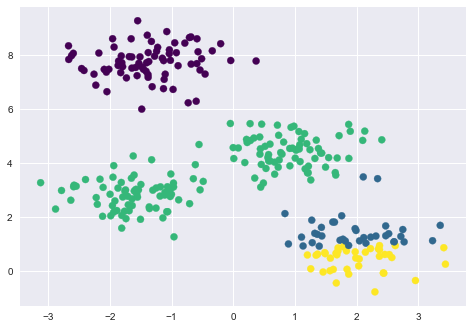

In [11]:
centers, labels = find_clusters(X,4,rseed=0)
plt.scatter(X[:,0], X[:,1], c = labels,
           s = 50, cmap = 'viridis');

Here, the EM approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algo to be run for multiple starting guesses, as indeed Scikit-learn does by default (set by the n_init param, which defaults to 10).

The no of clusters must be selected beforehand.

Another common challenge w k-means is that you must tell it how many clusters you expect: it cannot learn the no of clusters from the data. For eg, if we ask the algo to identify six clusters, it will happiliy proceed and find the best six clusters:

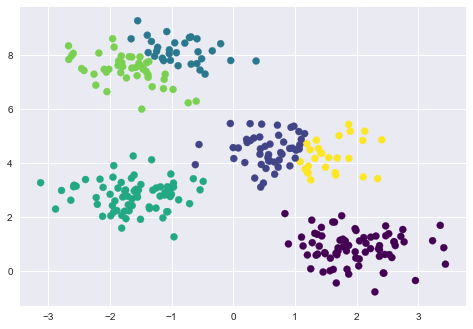

In [12]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c = labels,
           s = 50, cmap = 'viridis');

Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive, but that we wont' discuss further here is called, silhoutte analysis.

Alternatively, you might use a more complicated clustering algo which has a better quantitative measure of the fitness per no of clusters (eg Gaussian mixture models or which can choose a suitable no of clusters (eg DBSCAN, mean-shift, or affinity propagation)

Kmeans is limited to linear cluster boundaries.

The fundamental model assumptions of k-means (points will be closer to their own cluster center than to others) means that the algo will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between k-means clusters will always be linear, which means that it will fail for more complicated boundaries. Consider the following data, along w the cluster labels found by the typical k-means approach:

In [13]:
from sklearn.datasets import make_moons
X,y = make_moons(200, noise = 0.05, random_state=0)

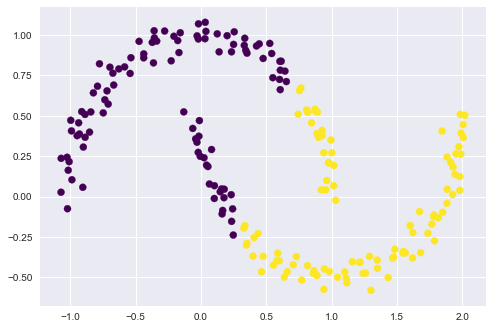

In [14]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c = labels,
           s = 50, cmap = 'viridis');

The situation is reminiscent of the discussion in SVM, where we used a kernel transformation to project the data into a higher dimension where a linear separation is possible. We might imagine using the same trick to allow k-means to discover non-linear boundaries.

One version of this kernelized k-means is implemented in Scikit-learn within the SpectralClustering estimator. It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a k-means algo:

/Users/indrikwijaya/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


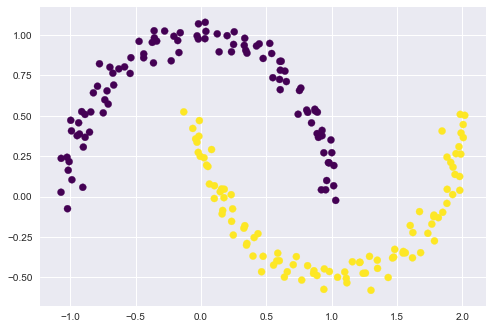

In [15]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity = 'nearest_neighbors',
                          assign_labels = 'kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:,0], X[:,1], c = labels,
           s = 50, cmap = 'viridis');

We see that this kernel transform approach, the kernelized k-means is able to find the more complicated nonlinear boundaries between clusters.

k-means can be slow for large no of samples

Bcos each iteration of k-means must access every point in the dataset, the algo can be relatively slow as the no of samples grows. You might wonder if this requirement to use all data at each iteration can be relaxed; for eg, you might just use a subset of the data to update the cluster centers at each step. This is the idea behind batch-based k-means algo, one form of which is implemented in sklearn.cluster.MiniBatchKMeans. The interface for this is the same as for standard KMeans; we will see an eg of its use as we continue our discussion.



# Eg
Being careful about these limitations of the algo, we can use k-means to our advantage in a wide variety of situations. We'll now take a look at a couple examples.



# Eg 1: k-means on digits
To start, let's take a look at applying k-means on the same simple digits data. Here we will attempt to use k-means to try to identify similar digits without using the original label information; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any a priori label information.

We will start by loading the digits and then finding KMeans clusters. Recall that the digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8x8 image:


In [16]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [17]:
kmeans = KMeans(n_clusters= 10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

The result is 10 clusters in 64 dimensions. Notice that the cluster centers themselves are 64-dim points, and can themselves be interpreted as the 'typical' digit within the cluster. Let's see what these cluster centers look like:

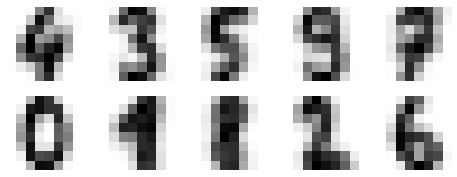

In [19]:
fig, ax = plt.subplots(2, 5, figsize = (8,3))
centers = kmeans.cluster_centers_.reshape(10,8,8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks= [], yticks=[])
    axi.imshow(center, interpolation = 'nearest', cmap =plt.cm.binary)

We see that even without the labels, Kmeans is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.

Because kmeans shows nothing about the identity of the cluser, the 0-9 labels, may be permuted. We can fix this by matching each learned cluster label with the true labels found in them:

In [20]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.79354479688369506

With just a simple k-means algo, we discovered the correct grouping for 80% of the input digits! Let's check the confusion matrix for this:

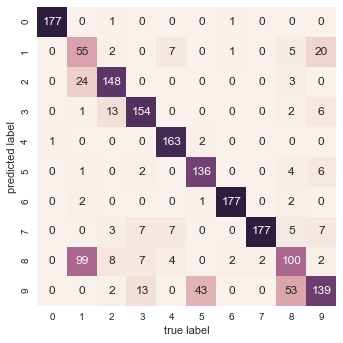

In [22]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square = True, annot = True, fmt='d', cbar = False,
           xticklabels = digits.target_names,
           yticklabels = digits.target_names)

plt.xlabel('true label')
plt.ylabel('predicted label')

As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones. But this still shows that using k-means, we can essentially build a digit classifier without reference to any known labels!

We can use the t-distributed stochastic neighbor embedding (t-SNE) algo to pre-process the data before performing k-means, t-SNE is non-linear embedding algo that is particularly adept at preserving points within clusters. 

In [23]:
from sklearn.manifold import TSNE

#Project the data: this step will take several seconds
tsne = TSNE(n_components = 2, init= 'random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

#Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

#Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters==i)
    labels[mask] = mode(digits.target[mask])[0]
    
#Compute the accuracy
accuracy_score(digits.target, labels)

0.91930996104618812

That's nearly 92% classification accuracy without using the labels. This is the power of unsupervised learning when used carefully: it can extract information from the dataset that it might be difficult to do by hand or by eye

# Eg 2: k-means for color compression

One interesting application of clustering is in color compression within images. For eg, imagine you have an image w millions of colors. In most images, a large no of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

For eg, consider the image shown in the following figure, which is from Scikit-learn datasets modile (need 'pillow' package to work)

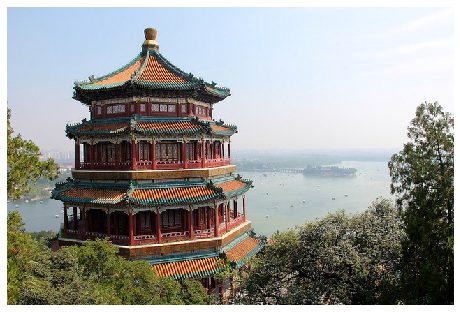

In [24]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

In [26]:
#stored in a 3d array of size (height, width, RGB), containing red/blue/green contributions
# integer from 0 to 255
china.shape

(427, 640, 3)

In [27]:
#reshape the data to [n_samples x n_features], and rescale the colors (0<=c<=1
data = china /255.0 
data = data.reshape(427 *640, 3)
data.shape

(273280, 3)

In [32]:
#visualise using a subset of 10,000 pixels for efficiency

def plot_pixels(data, title, colors = None, N = 10000):
    if colors is None:
        colors = data
        
    #choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize = (16,6))
    ax[0].scatter(R, G, color =colors, marker = '.')
    ax[0].set(xlabel = 'Red', ylabel = 'Green', xlim = (0,1), ylim = (0,1))
    
    ax[1].scatter(R, B, color = colors, marker = '.')
    ax[1].set(xlabel = 'Red', ylabel = 'Blue', xlim = (0,1), ylim = (0,1))
    
    fig.suptitle(title, size = 20);
    

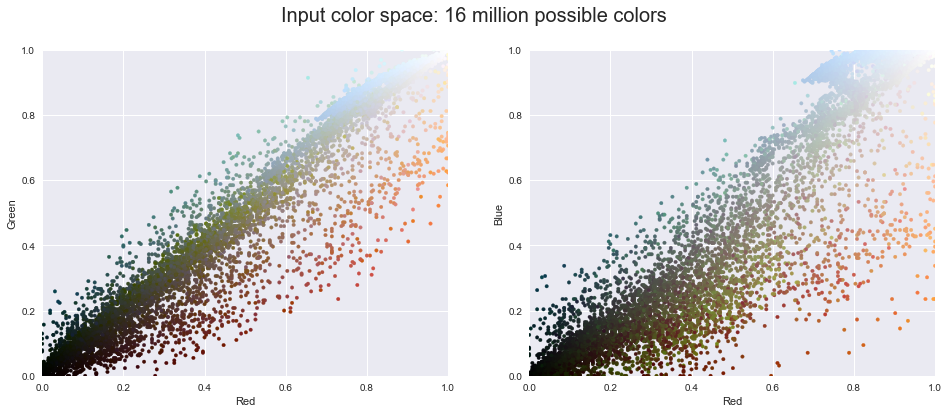

In [33]:
plot_pixels(data, title = 'Input color space: 16 million possible colors')

Let's reduce these 16 million colors to just 16 colors, using a k-means clustering across the pixel space. Because we are dealing with a very large dataset, we will use mini batch k-means, which operates on subsets of the data to compute the result much more quickly than the standard k-means algo:

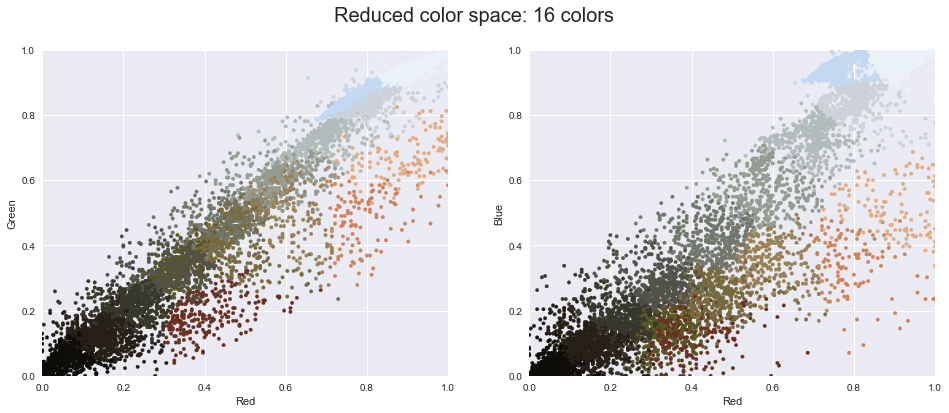

In [35]:
import warnings; warnings.simplefilter('ignore') #fix numpy issues

from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors = new_colors,
           title = 'Reduced color space: 16 colors')

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center. Plotting these new colors in the image space rather than the pixel space shows us the effect of this:

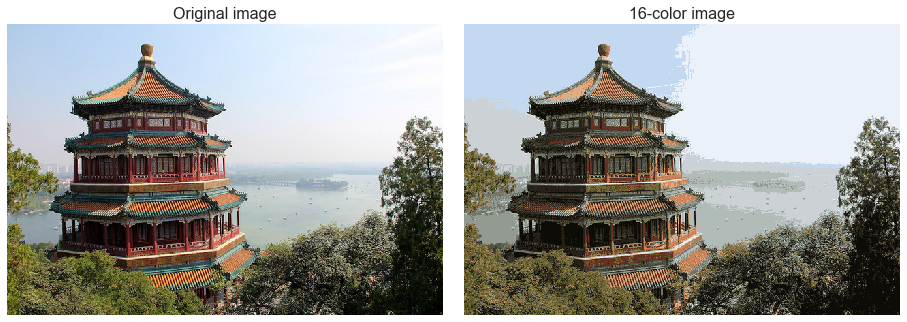

In [37]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1,2,figsize=(16,6),
                      subplot_kw = dict(xticks=[], yticks=[]))

fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original image', size = 16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color image', size = 16)

Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable. This image on the right achieves a compression factor of around 1 million! While this is an interesting application of k-means, there are certainly better way to compress information in images. But the example shows the power of thinking outside of the box with unsupervised methods like k-means.